# Instructions
You will submit an HTML document to Canvas as your final version.  

Your document should show your code chunks/cells as well as any output. Make sure that only relevant output is printed. Do not, for example, print the entire dataset in your final rendered file.  

Your document should also be clearly organized, so that it is easy for a reader to find your answers to each question.

# The Data
In this lab, we will use medical data to predict the likelihood of a person experiencing an exercise-induced heart attack.  

Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise. The information collected includes:  

- **age**: Age of the patient
- **sex**: Sex of the patient
- **cp**: Chest Pain type
  - Value 0: asymptomatic
  - Value 1: typical angina
  - Value 2: atypical angina
  - Value 3: non-anginal pain
- **trtbps**: Resting blood pressure (in mm Hg)
- **chol**: Cholesterol in mg/dl fetched via BMI sensor
- **restecg**: Resting electrocardiographic results
  - Value 0: normal
  - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
  - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- **thalach**: Maximum heart rate achieved during exercise
- **output**: The doctor’s diagnosis of whether the patient is at risk for a heart attack
  - 0 = not at risk of heart attack
  - 1 = at risk of heart attack

Although it is not a formal question on this assignment, you should begin by reading in the dataset and briefly exploring and summarizing the data, and by adjusting any variables that need cleaning.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve, cohen_kappa_score, classification_report, roc_curve, auc
from plotnine import *

In [3]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [4]:
ha.describe()

,age,sex,cp,trtbps,chol,restecg,thalach,output
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,54.347985,0.673993,0.974359,132.098901,246.860806,0.538462,149.446886,0.534799
std,9.163134,0.469611,1.030456,17.700358,52.569726,0.528059,23.240707,0.499704
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,71.000000,0.000000
25%,47.000000,0.000000,0.000000,120.000000,211.000000,0.000000,133.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.000000,1.000000,152.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.000000,1.000000,166.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,2.000000,202.000000,1.000000


The dataset has 273 observations. The patients’ ages range from 29 to 77, with an average in their mid-50s. There are slightly more male patients, and about half of all patients are at risk of a heart attack. Cholesterol and blood pressure levels vary widely, reflecting differences in patient health. Chest pain types and ECG results are evenly spread across their categories. Overall, the data is clean, with no missing values, and ready for analysis.

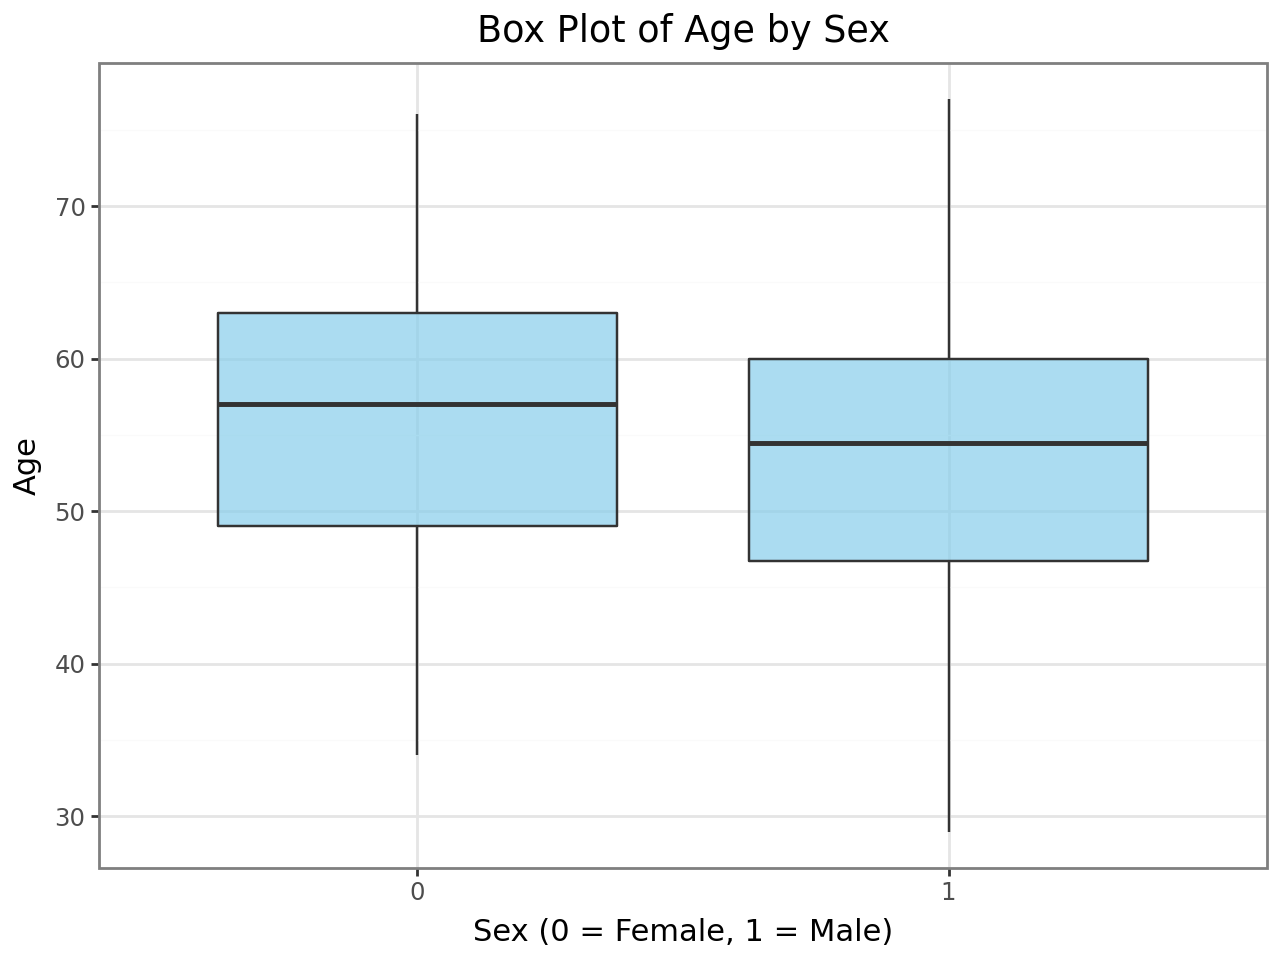

In [5]:
(ggplot(ha, aes(x='factor(sex)', y='age')) +
    geom_boxplot(fill='skyblue', alpha=0.7) +
    labs(title="Box Plot of Age by Sex", 
         x="Sex (0 = Female, 1 = Male)",
         y="Age") +
    theme_bw()
)

The box plot shows the age distribution for males (sex = 1) and females (sex = 0). Both groups have a similar age range and variability. The median age is slightly higher for females, meaning they might be older on average in this dataset. There don’t seem to be any major outliers in either group based on the plot.

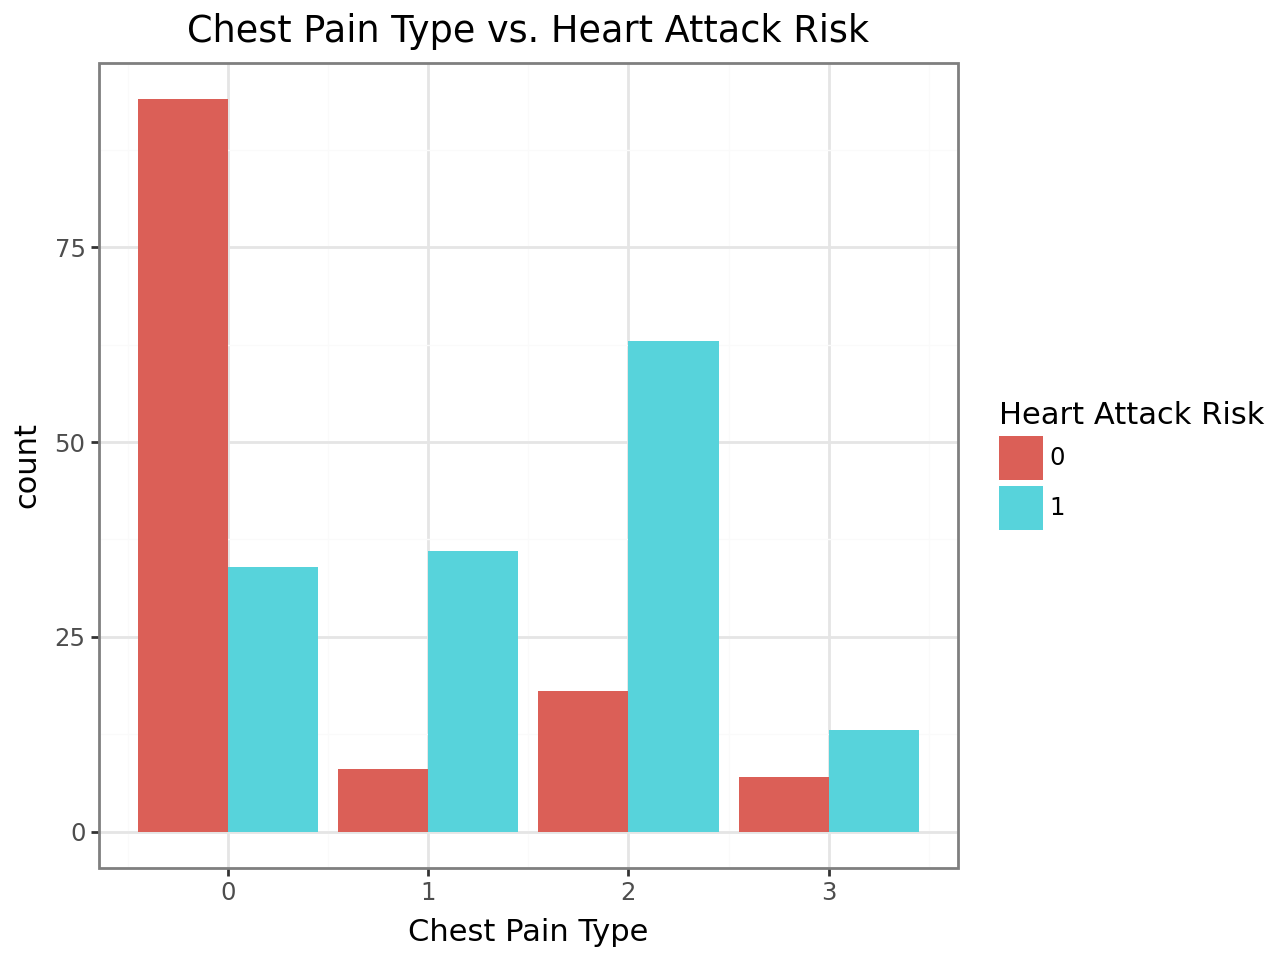

In [6]:
(ggplot(ha, aes(x='cp', fill='factor(output)')) +
    geom_bar(position='dodge') +
    labs(title="Chest Pain Type vs. Heart Attack Risk",
         x="Chest Pain Type",
         fill="Heart Attack Risk") +
    theme_bw()
)

This bar plot shows the relationship between chest pain type (cp) and heart attack risk (output). Most patients with asymptomatic chest pain (type 0) are at no risk (output = 0). On the other hand, patients with chest pain types 1, 2, and 3 (typical angina, atypical angina, and non-anginal pain) are mostly at risk of a heart attack (output = 1). This suggests that less common chest pain types are linked to a higher risk, making chest pain type a potential key factor in predicting heart attack risk.

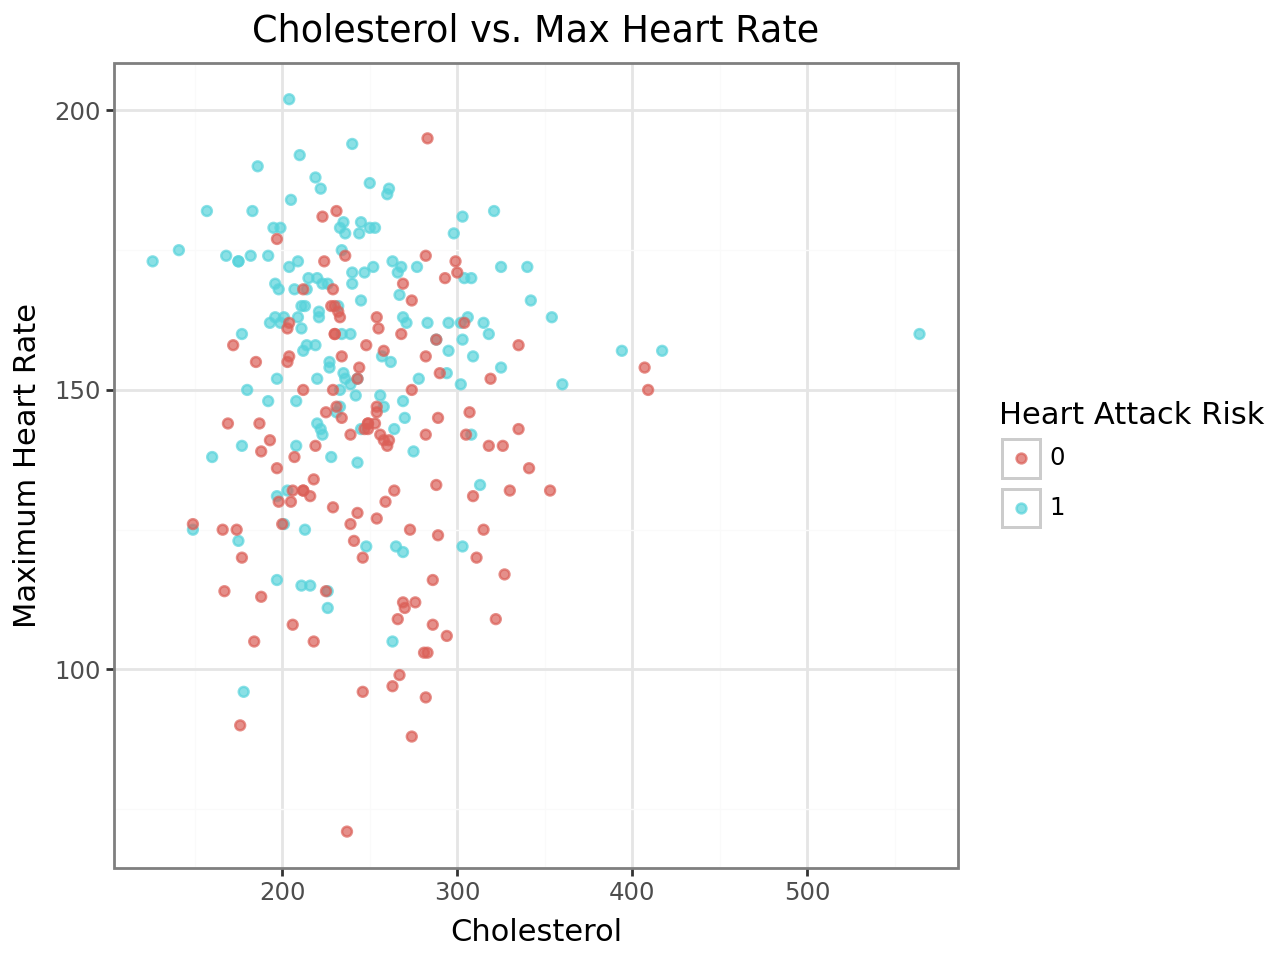

In [7]:
(ggplot(ha, aes(x='chol', y='thalach', color='factor(output)')) +
    geom_point(alpha=0.7) +
    labs(title="Cholesterol vs. Max Heart Rate",
         x="Cholesterol",
         y="Maximum Heart Rate",
         color="Heart Attack Risk") +
    theme_bw()
)

This scatterplot shows no clear relationship between cholesterol and maximum heart rate. Patients at both risk levels (output = 0 and output = 1) are spread across cholesterol values, though very high cholesterol (over 400 mg/dL) is uncommon. Similarly, heart attack risk happens across all heart rate levels without any strong pattern. This suggests that cholesterol and heart rate might not be strong predictors on their own, but they could still add useful information when combined with other factors.

In [ ]:
X = ha.drop(columns=['output'])
y = ha['output']

# Calculate correlation matrix for predictors
correlation_matrix = X.corr()
correlation_matrix

,age,sex,cp,trtbps,chol,restecg,thalach
age,1.000000,-0.100841,-0.096004,0.308021,0.220130,-0.100412,-0.403412
sex,-0.100841,1.000000,-0.062922,-0.054932,-0.208995,-0.090094,-0.036794
cp,-0.096004,-0.062922,1.000000,0.059199,-0.079811,0.059249,0.308125
trtbps,0.308021,-0.054932,0.059199,1.000000,0.147251,-0.137880,-0.056877
chol,0.220130,-0.208995,-0.079811,0.147251,1.000000,-0.131053,-0.012705
restecg,-0.100412,-0.090094,0.059249,-0.137880,-0.131053,1.000000,0.048922
thalach,-0.403412,-0.036794,0.308125,-0.056877,-0.012705,0.048922,1.000000


Most of the predictors show weak correlations with each other, as most values are close to 0. This suggests there isn’t strong multicollinearity in the dataset, which is good for modeling.

In [9]:
correlations_with_target = X.corrwith(y)
correlations_with_target.sort_values(key=abs, ascending=False) 

cp         0.419420
thalach    0.413995
sex       -0.303982
age       -0.239918
restecg    0.144686
trtbps    -0.136519
chol      -0.078189
dtype: float64

The correlation values show that **cp** (0.419) and **thalach** (0.414) have the strongest positive relationships with the target variable output, making them likely important predictors. Meanwhile, **sex** (-0.304) and **age** (-0.240) show moderate negative correlations with the target, suggesting some predictive potential. It appears that **chol** (-0.078), **trtbps** (-0.137), and **restecg** (0.145) have the weakest correlations, indicating they may not significantly contribute to predicting the outcome.

# Part One: Fitting Models
This section asks you to create a final best model for each of the model types studied this week. For each, you should:

- Find the best model based on ROC AUC for predicting the target variable.
- Report the (cross-validated!) ROC AUC metric.
- Fit the final model.
- Output a confusion matrix; that is, the counts of how many observations fell into each predicted class for each true class.
- (Where applicable) Interpret the coefficients and/or estimates produced by the model fit.

You should certainly try multiple model pipelines to find the best model. You do not need to include the output for every attempted model, but you should describe all of the models explored. You should include any hyperparameter tuning steps in your writeup as well.

## Q1: KNN

In [10]:
# Split features and target variable
X = ha.drop(columns=['output'])
y = ha['output']
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define ColumnTransformer
knn_ct = ColumnTransformer(
    [
      ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"), ["sex", "cp", "restecg"]),
      ("standardize", StandardScaler(), ["age", "thalach"])
    ],
    remainder = "drop"
)

# Define KNN pipeline
knn_pipeline = Pipeline([
    ("preprocessor", knn_ct),
    ("knn", KNeighborsClassifier())]
)

param_grid = {'knn__n_neighbors': range(1, 21)}
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=stratified_cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X, y)

best_k = grid_search.best_params_['knn__n_neighbors']
best_score = grid_search.best_score_
print(f"Best k: {best_k}")
print(f"Best cross-validated ROC AUC: {best_score:.4f}")

Best k: 16
Best cross-validated ROC AUC: 0.8421


I started with a KNN model using all of the predictors, optimizing the number of neighbors (k) using a grid search and cross-validation based on the ROC AUC metric. The best k was found to be 8, with a cross-validated ROC AUC of 0.7975. To improve model performance, I tested removing individual predictors and combinations of predictors based on their correlation with the target variable (output) and contribution to ROC AUC. Features with low correlation to the target, such as **chol** (-0.078) and **restecg** (0.144), were identified as potential candidates for removal. The final model uses the following 5 predictors: **age**, **sex**, **cp**, **restecg**, **thalach**. These features, paired with the optimal k of 8, provided the highest ROC AUC of 0.8421.

- ROC AUC with all predictors: 0.7975
- ROC AUC with all predictors except "chol": 0.8183
- ROC AUC with all predictors except "trtbps": 0.8292
- ROC AUC with all predictors except "restecg": 0.8063
- ROC AUC with all predictors except "chol" and "trtbps": **0.8421**
- ROC AUC with all predictors except "chol" and "restecg": 0.8148
- ROC AUC with all predictors except "chol", "trtbps", and "restecg": 0.8184

In [11]:
# Define the final pipeline
final_knn_pipeline = Pipeline([
    ("preprocessor", knn_ct),
    ("knn", KNeighborsClassifier(n_neighbors=best_k))]
)

# Fit the final pipeline
final_knn_pipeline.fit(X, y)

# Predict classes on the test set
y_pred = final_knn_pipeline.predict(X)

# Generate and display the confusion matrix
knn_cm = confusion_matrix(y, y_pred)
print("Confusion Matrix:")
print(knn_cm)

# Performance metrics
print("Classification Report:")
print(classification_report(y, y_pred))

# Predict probabilities and calculate ROC AUC
y_pred_proba_knn = final_knn_pipeline.predict_proba(X)[:, 1]
knn_roc_auc = roc_auc_score(y, y_pred_proba_knn)
print(f"ROC AUC: {knn_roc_auc:.4f}")

Confusion Matrix:
[[109  18]
 [ 42 104]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.86      0.78       127
           1       0.85      0.71      0.78       146

    accuracy                           0.78       273
   macro avg       0.79      0.79      0.78       273
weighted avg       0.79      0.78      0.78       273

ROC AUC: 0.8677


The confusion matrix and classification report show that the KNN model performs with an overall accuracy of **78%**. 

- For the negative class (`0` - not at risk of heart attack), the model achieves a precision of **72%** and a recall of **86%**, indicating that 72% of predicted negatives were correct, while 86% of actual negatives were correctly identified. 
- For the positive class (`1` - at risk of heart attack), the model achieves a precision of **85%** and a recall of **71%**, meaning that 85% of predicted positives were correct, while 71% of actual positives were identified. 

The F1-score is **0.78** for both classes, reflecting a good balance between precision and recall. The confusion matrix shows that the model correctly identified **109 true negatives** and **104 true positives**, but misclassified **18 negatives as positives** (false positives) and **42 positives as negatives** (false negatives). The model shows balanced performance overall but could be improved by reducing false negatives. The model achieves a strong ROC AUC of **0.8677**.

## Q2: Logistic Regression

In [12]:
# Split features and target variable
X = ha.drop(columns=['output'])
y = ha['output']
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

logreg_ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop="first"), ["sex", "cp", "restecg"]),
        ("standardize", StandardScaler(), ["age", "chol", "trtbps", "thalach"]),
    ],
    remainder="drop"
)

# Define the pipeline
logreg_pipeline = Pipeline([
    ("preprocessor", logreg_ct),
    ("logreg", LogisticRegression(max_iter=1000))]
)

# Define the parameter grid for Logistic Regression
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'logreg__penalty': ['l1', 'l2'],  # Regularization type
    'logreg__solver': ['liblinear']  # Solver compatible with L1 and L2
}

# Perform GridSearchCV
grid_search = GridSearchCV(logreg_pipeline, param_grid, cv=stratified_cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X, y)

# Get the best parameters and cross-validated ROC AUC
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validated ROC AUC: {best_score:.4f}")

Best parameters: {'logreg__C': 1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best cross-validated ROC AUC: 0.8578


Just like for KNN, I began building the Logistic Regression model using all predictors. The model with all predictors performed slightly better than the others, achieving the highest cross-validated ROC AUC of **0.8578**. This model uses L1 regularization (`penalty = 'l2'`), a regularization strength of `C = 1`, and the `liblinear` solver.

To refine the model, I tested removing individual predictors and combinations of predictors. While removing some predictors, such as **chol** or **restecg**, slightly reduced performance, the drop in ROC AUC was minimal. For example, removing **restecg** resulted in a cross-validated ROC AUC of **0.8573**, and removing both **chol** and **restecg** gave an ROC AUC of **0.8566**. These results suggest that all predictors contribute to the model's performance, but none are overwhelmingly influential individually.


- ROC AUC with all predictors: **0.8578**
- ROC AUC with all predictors except "chol": 0.8504
- ROC AUC with all predictors except "trtbps": 0.8465
- ROC AUC with all predictors except "restecg": 0.8573
- ROC AUC with all predictors except "chol" and "trtbps": 0.8478
- ROC AUC with all predictors except "chol" and "restecg": 0.8566
- ROC AUC with all predictors except "trtbps" and "restecg": 0.8508
- ROC AUC with all predictors except "chol", "trtbps", and "restecg": 0.8478

In [13]:
# Define the final pipeline
final_logreg_pipeline = Pipeline([
    ("preprocessor", logreg_ct),
    ("logreg", LogisticRegression(C=1, penalty='l2', solver='liblinear', max_iter=1000))]
)

# Fit the final pipeline
final_logreg_pipeline.fit(X, y)

# Predict classes on the test set
y_pred = final_logreg_pipeline.predict(X)

# Generate and display the confusion matrix
logreg_cm = confusion_matrix(y, y_pred)
print("Confusion Matrix:")
print(logreg_cm)

# Performance metrics
print("Classification Report:")
print(classification_report(y, y_pred))

# Predict probabilities and calculate ROC AUC
y_pred_proba_logreg = final_logreg_pipeline.predict_proba(X)[:, 1]
logreg_roc_auc = roc_auc_score(y, y_pred_proba_logreg)
print(f"Test ROC AUC: {logreg_roc_auc:.4f}")

Confusion Matrix:
[[ 96  31]
 [ 23 123]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.76      0.78       127
           1       0.80      0.84      0.82       146

    accuracy                           0.80       273
   macro avg       0.80      0.80      0.80       273
weighted avg       0.80      0.80      0.80       273

Test ROC AUC: 0.8801


The confusion matrix and classification report show that the Logistic Regression model performs with an overall accuracy of **80%**. 

- For the negative class (`0` - not at risk of heart attack), the model achieves a precision of **81%** and a recall of **76%**, indicating that 81% of predicted negatives were correct, while 76% of actual negatives were correctly identified. 
- For the positive class (`1` - at risk of heart attack), the model achieves a precision of **80%** and a recall of **84%**, meaning that 80% of predicted positives were correct, while 84% of actual positives were identified.

The F1-score is **0.78** for the negative class and **0.82** for the positive class. The confusion matrix shows that the model correctly identified **96 true negatives** and **123 true positives**, while misclassifying **31 negatives as positives** (false positives) and **23 positives as negatives** (false negatives). The model demonstrates strong performance in identifying at-risk patients, achieving a robust test ROC AUC of **0.8801**. However, reducing false negatives, where at-risk patients are incorrectly classified as not at risk, could further improve the model’s effectiveness.

In [14]:
# Extract coefficients and features
coefficients = final_logreg_pipeline.named_steps['logreg'].coef_.flatten()
features = logreg_ct.get_feature_names_out()
logreg_coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

# Sort by absolute value of coefficients
logreg_coef_df = logreg_coef_df.sort_values(by='Coefficient', key=abs, ascending=False) 
print("Feature Coefficients:")
print(logreg_coef_df)

Feature Coefficients:
                Feature  Coefficient
0        dummify__sex_1    -1.771709
1         dummify__cp_1     1.646944
2         dummify__cp_2     1.626435
3         dummify__cp_3     1.253831
9  standardize__thalach     0.771272
4    dummify__restecg_1     0.354413
8   standardize__trtbps    -0.292355
7     standardize__chol    -0.255847
5    dummify__restecg_2    -0.229062
6      standardize__age    -0.206870


Interpretation of Coefficients:

- **sex_1 (Male):**
  - Being male decreases the likelihood of being at risk of a heart attack compared to being female, with a coefficient of **-1.77**. This is the strongest negative predictor in the model.

- **cp_1 (Chest Pain Type 1 - Typical Angina):**
  - Patients with typical angina have a significantly higher likelihood of being at risk of a heart attack compared to the reference group (`cp_0` - asymptomatic chest pain), with a coefficient of **1.65**. This is one of the strongest positive predictors in the model.

- **cp_2 (Chest Pain Type 2 - Atypical Angina):**
  - Atypical angina increases the likelihood of being at risk compared to the asymptomatic group, with a coefficient of **1.63**. The effect is similar in strength to `cp_1`.

- **cp_3 (Chest Pain Type 3 - Non-Anginal Pain):**
  - Patients with non-anginal pain are also more likely to be at risk compared to the asymptomatic group, with a coefficient of **1.25**, though the effect is slightly weaker than `cp_1` and `cp_2`.

- **thalach (Maximum Heart Rate):**
  - A 1-standard deviation increase in maximum heart rate is associated with a higher likelihood of being at risk of a heart attack, with a coefficient of **0.77**. This is the most influential numerical predictor in the model.

- **restecg_1 (Resting ECG - Having ST-T Wave Abnormality):**
  - Patients with an ST-T wave abnormality (compared to a normal ECG, `restecg_0`) are slightly more likely to be at risk of a heart attack, with a coefficient of **0.35**.

- **trtbps (Resting Blood Pressure):**
  - A 1-standard deviation increase in resting blood pressure slightly decreases the likelihood of being at risk, with a coefficient of **-0.29**, indicating minimal influence.

- **chol (Cholesterol):**
  - A 1-standard deviation increase in cholesterol slightly decreases the likelihood of being at risk of a heart attack, with a coefficient of **-0.25**. The impact is relatively small.

- **restecg_2 (Resting ECG - Showing Left Ventricular Hypertrophy):**
  - Patients with left ventricular hypertrophy (compared to a normal ECG, `restecg_0`) are slightly less likely to be at risk of a heart attack, with a coefficient of **-0.23**.

- **age (Age):**
  - A 1-standard deviation increase in age weakly decreases the likelihood of being at risk of a heart attack, with a coefficient of **-0.20**. This suggests that age may not be a strong predictor in this model.

## Q3: Decision Trees

In [15]:
# Split features and target variable
X = ha.drop(columns=['output'])
y = ha['output']
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

dt_ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop="first"), ["sex", "cp", "restecg"]),
        ("standardize", StandardScaler(), ["age", "thalach"]),
    ],
    remainder="drop"
)

# Define the pipeline
dt_pipeline = Pipeline([
    ("preprocessor", dt_ct),
    ("dt", DecisionTreeClassifier(random_state=1))]
)

# Define parameter grid
param_grid = {
    "dt__max_depth": [2, 4, 6, 8, 10, None],
    "dt__min_samples_split": [2, 5, 10],
    "dt__min_samples_leaf": [1, 2, 4],
    "dt__ccp_alpha": [0.0, 0.005, 0.01, 0.02, 0.1]
}

# Perform GridSearchCV
grid_search = GridSearchCV(dt_pipeline, param_grid, cv=stratified_cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X, y)

# Get the best parameters and ROC AUC
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validated ROC AUC: {best_score:.4f}")


Best parameters: {'dt__ccp_alpha': 0.0, 'dt__max_depth': 4, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 5}
Best cross-validated ROC AUC: 0.7874


The Decision Tree model was optimized using a grid search across hyperparameters (`max_depth`, `min_samples_split`, `min_samples_leaf`, and `ccp_alpha`). The best model, with **`ccp_alpha` = 0.0**, **`max_depth` = 4**, **`min_samples_split` = 5**, and **`min_samples_leaf` = 2**, achieved a cross-validated ROC AUC of **0.7874**. 

Removing individual predictors showed minimal improvement, but excluding both **chol** and **trtbps** increased the ROC AUC from **0.7405** to **0.7874**. The final model includes **age**, **sex**, **cp**, **thalach**, and **restecg**.

- ROC AUC with all predictors: 0.7405
- ROC AUC with all predictors except "chol": 0.7370
- ROC AUC with all predictors except "trtbps": 0.7474
- ROC AUC with all predictors except "restecg": 0.7405
- ROC AUC with all predictors except "chol" and "trtbps": **0.7874**
- ROC AUC with all predictors except "chol" and "restecg": 0.7370
- ROC AUC with all predictors except "trtbps" and "restecg": 0.7529
- ROC AUC with all predictors except "chol", "trtbps", and "restecg": 7871

In [16]:
# Define the final pipeline
final_dt_pipeline = Pipeline([
    ("preprocessor", dt_ct),
    ("dt", DecisionTreeClassifier(ccp_alpha=0.0, max_depth=4, min_samples_leaf=2, min_samples_split=5, random_state=1))
])

# Fit the final pipeline
final_dt_pipeline.fit(X, y)

# Predict classes on the test set
y_pred = final_dt_pipeline.predict(X)

# Generate and display the confusion matrix
dt_cm = confusion_matrix(y, y_pred)
print("Confusion Matrix:")
print(dt_cm)

# Performance metrics
print("Classification Report:")
print(classification_report(y, y_pred))

# Predict probabilities and calculate ROC AUC
y_pred_proba_dt = final_dt_pipeline.predict_proba(X)[:, 1]
dt_roc_auc = roc_auc_score(y, y_pred_proba_dt)
print(f"Test ROC AUC: {dt_roc_auc:.4f}")


Confusion Matrix:
[[ 97  30]
 [ 25 121]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       127
           1       0.80      0.83      0.81       146

    accuracy                           0.80       273
   macro avg       0.80      0.80      0.80       273
weighted avg       0.80      0.80      0.80       273

Test ROC AUC: 0.8778


The confusion matrix and classification report show that the Decision Tree model performs with an overall accuracy of **80%**.

- For the negative class (0 - not at risk of heart attack), the model achieves a precision of **88%** and a recall of **76%**, indicating that 88% of predicted negatives were correct, while 76% of actual negatives were correctly identified.
- For the positive class (1 - at risk of heart attack), the model achieves a precision of **80%** and a recall of **83%**, meaning that 80% of predicted positives were correct, while 83% of actual positives were identified.

The F1-score is **0.78** for the negative class and **0.81** for the positive class. The confusion matrix shows that the model correctly identified **97 true negatives** and **121 true positives**, while misclassifying **30 negatives as positives** (false positives) and **25 positives as negatives** (false negatives). The model demonstrates strong performance in identifying at-risk patients, achieving a robust test ROC AUC of **0.8778**. However, reducing false negatives, where at-risk patients are incorrectly classified as not at risk, could further improve the model’s effectiveness.

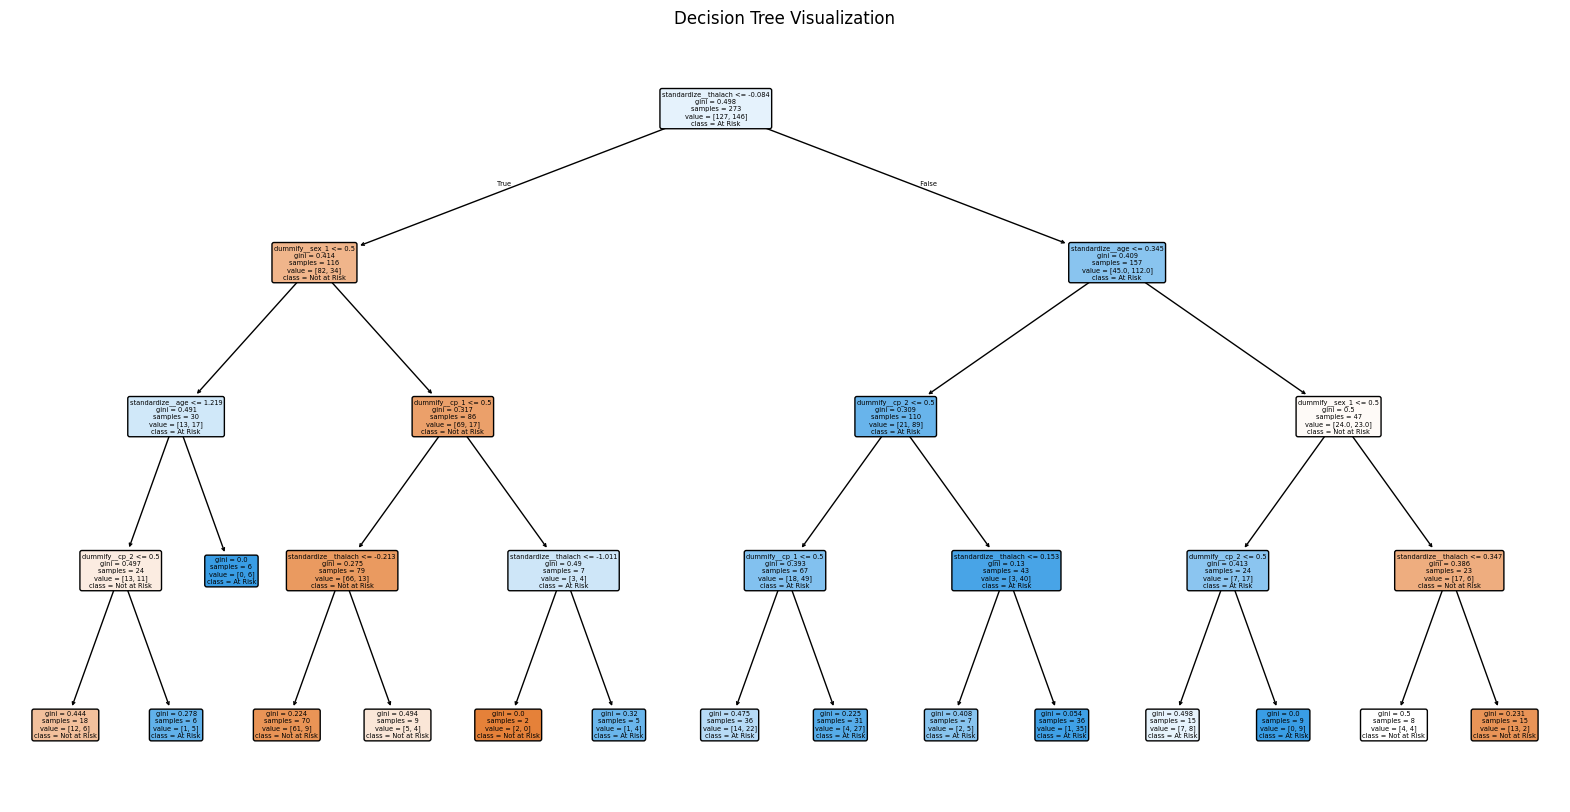

In [17]:
# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    final_dt_pipeline.named_steps["dt"],
    feature_names=dt_ct.get_feature_names_out(),
    class_names=["Not at Risk", "At Risk"],
    filled=True,
    rounded=True
)
plt.title("Decision Tree Visualization")
plt.show()


This decision tree uses important features like maximum heart rate ("standardized_thalach"), gender ("dummyfied_sex"), age, and chest pain type to predict heart attack risk. The first split is made based on maximum heart rate, showing it’s the most important factor. Other splits refine the predictions by combining these features. The tree ends in leaf nodes, where each patient is classified as at risk or not at risk based on the majority of cases in that group.

## Q4: Interpretation  
Which predictors were most important to predicting heart attack risk?

Across all models, **thalach** (maximum heart rate) consistently emerged as one of the most important predictors, shown by its role as the first split in the Decision Tree and its strong coefficient in Logistic Regression. The chest pain types (**cp_1**, **cp_2**, **cp_3**) were also crucial, significantly contributing to predictions across Logistic Regression and Decision Trees. **Sex** was another key factor, with males (**sex_1**) showing a lower likelihood of heart attack risk in Logistic Regression and influencing splits in the Decision Tree. In contrast, **chol** (cholesterol), **restecg** (resting ECG results), and **trtbps** (resting blood pressure) were often excluded or had weaker importance, suggesting they are less critical for predicting heart attack risk in this dataset.

## Q5: ROC Curve  
Plot the ROC Curve for your three models above.

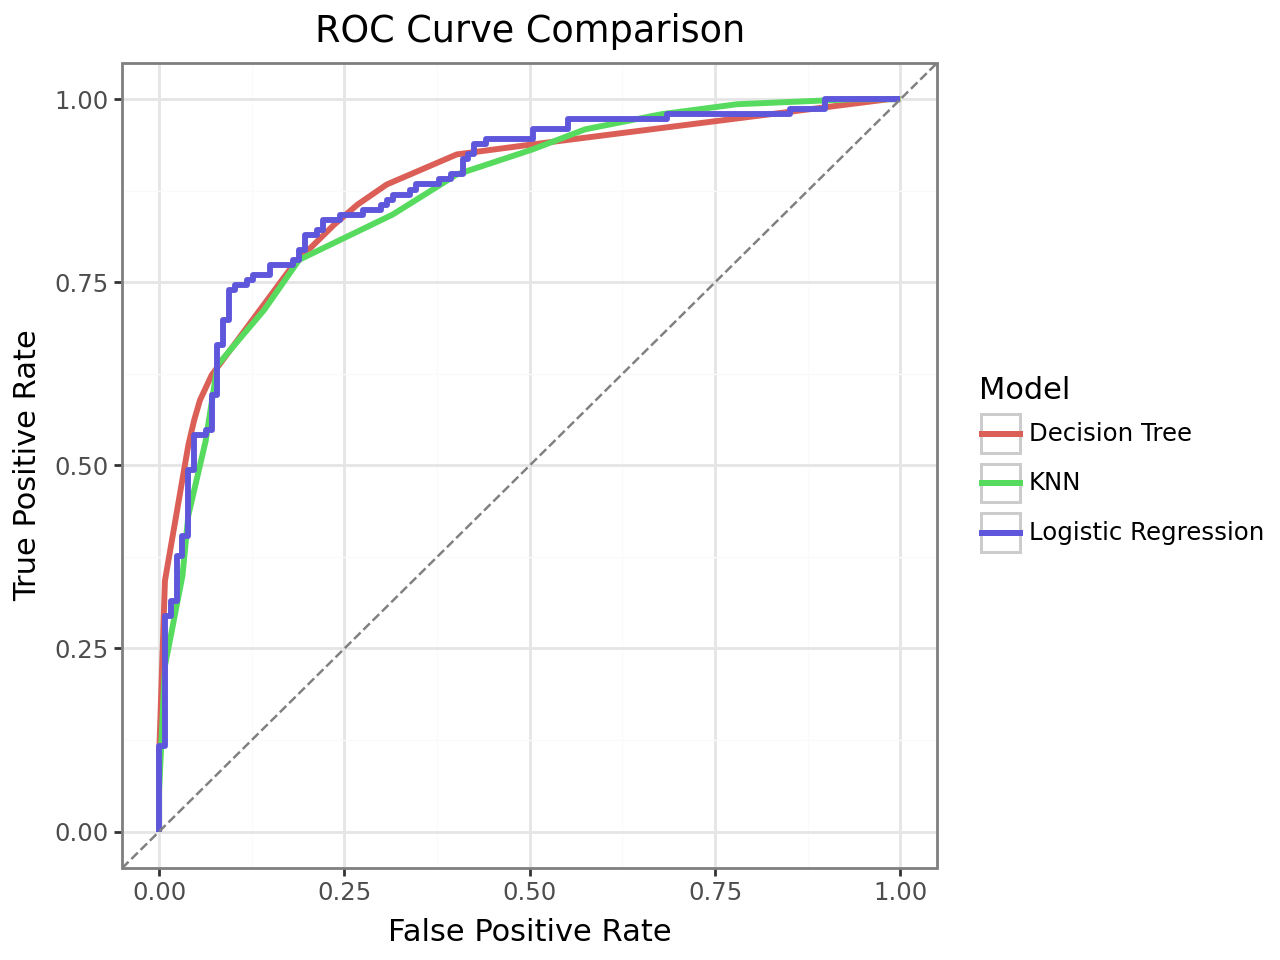

In [18]:
# Compute FPR, TPR, and AUC for each model
fpr_knn, tpr_knn, _ = roc_curve(y, y_pred_proba_knn)
auc_knn = auc(fpr_knn, tpr_knn)

fpr_logreg, tpr_logreg, _ = roc_curve(y, y_pred_proba_logreg)
auc_logreg = auc(fpr_logreg, tpr_logreg)

fpr_dt, tpr_dt, _ = roc_curve(y, y_pred_proba_dt)
auc_dt = auc(fpr_dt, tpr_dt)

# Create a DataFrame for plotting
roc_data = pd.DataFrame({
    "False Positive Rate": list(fpr_knn) + list(fpr_logreg) + list(fpr_dt),
    "True Positive Rate": list(tpr_knn) + list(tpr_logreg) + list(tpr_dt),
    "Model": (["KNN"] * len(fpr_knn)) + (["Logistic Regression"] * len(fpr_logreg)) + (["Decision Tree"] * len(fpr_dt))
})

# Plot the ROC curves
(ggplot(roc_data, aes(x="False Positive Rate", y="True Positive Rate", color="Model")) +
    geom_line(size=1.2) +
    geom_abline(linetype="dashed", color="gray") +
    labs(title="ROC Curve Comparison",
        x="False Positive Rate",
        y="True Positive Rate",
        color="Model") +
    theme_bw()
)

Logistic Regression appears to show the highest area under the curve (AUC), indicating better overall performance in balancing true positive and false positive rates. The Decision Tree and KNN models perform similarly, with slightly lower AUC values compared to Logistic Regression. All models show good separation ability, but Logistic Regression appears to have a slight edge in predictive accuracy for this dataset.

# Part Two: Metrics

Consider the following metrics:  

- **True Positive Rate** or **Recall** or **Sensitivity**  
  Of the observations that are truly Class A, how many were predicted to be Class A?  

- **Precision** or **Positive Predictive Value**  
  Of all the observations classified as Class A, how many of them were truly from Class A?  

- **True Negative Rate** or **Specificity** or **Negative Predictive Value**  
  Of all the observations classified as NOT Class A, how many were truly NOT Class A?

Compute each of these metrics (cross-validated) for your three models (KNN, Logistic Regression, and Decision Tree) in Part One.

In [19]:
def compute_metrics(model_pipeline, X, y, cv):
    # Get cross-validated predictions
    y_pred = cross_val_predict(model_pipeline, X, y, cv=cv)
    
    # Compute confusion matrix and extract TN, FP, FN, TP
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    
    # Compute metrics
    recall = recall_score(y, y_pred, pos_label=1)  # True Positive Rate (Sensitivity)
    precision = precision_score(y, y_pred, pos_label=1)
    specificity = tn / (tn + fp)  # True Negative Rate
    
    return precision, recall, specificity

# Define a list of models and names
models = [
    ("KNN", final_knn_pipeline),
    ("Logistic Regression", final_logreg_pipeline),
    ("Decision Tree", final_dt_pipeline)
]

# Compute metrics for each model
metrics = []
for name, pipeline in models:
    precision, recall, specificity = compute_metrics(pipeline, X, y, stratified_cv)
    metrics.append({"Model": name, "Recall": recall, "Precision": precision, "Specificity": specificity})

# Convert metrics to a DataFrame
metrics_df = pd.DataFrame(metrics)
metrics_df

,Model,Recall,Precision,Specificity
0,KNN,0.691781,0.834711,0.842520
1,Logistic Regression,0.821918,0.789474,0.748031
2,Decision Tree,0.753425,0.743243,0.700787


# Part Three: Discussion  
Suppose you have been hired by a hospital to create classification models for heart attack risk.  

The following questions give a possible scenario for why the hospital is interested in these models. For each one, discuss:  

- Which metric(s) you would use for model selection and why.  
- Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.  
- What score you should expect for your chosen metric(s) using your chosen model to predict future observations.  

## Q1  
The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

If the hospital faces lawsuits for misclassifying at-risk patients as low-risk, recall (sensitivity) is the most critical metric. High recall ensures the model identifies most at-risk patients, reducing the chance of overlooking someone who may experience a heart attack. Based on recall, logistic regression is the best choice, achieving a recall of 0.82, significantly higher than KNN (0.69) and decision tree (0.75). Using this model, the hospital can expect it to identify 82% of at-risk patients correctly.

## Q2  
The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

When the hospital is overfull and aims to prioritize monitoring only the highest-risk patients, precision is the key metric. Precision ensures that most patients flagged as high-risk are truly at risk. The KNN model has the highest precision (0.83) compared to logistic regression (0.79) and decision tree (0.74). With KNN, the hospital can expect that 83% of patients predicted as at-risk genuinely require monitoring.

## Q3  
The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

To study the biological causes of heart attacks, it is important to select a model with interpretable features. Logistic regression is the most interpretable model due to its coefficients, which quantify the effect of each predictor (e.g., chest pain types, maximum heart rate) on the risk of a heart attack. Using this model, the hospital can expect a recall of 0.82 and precision of 0.79, while also gaining valuable insights into how each biological measure contributes to heart attack risk. However, if we wanted to select a model for studying root causes of heart attacks based on metrics, precision is the most suitable metric since it minimizes false positives, ensuring that patients identified as at risk are truly at risk. This reduces the risk of misleading associations between biological measures and heart attack risk. The KNN model would then be reccommended because it achieved the highest precision (0.83) among the models. Using this model, the hospital can expect a precision of 0.83 in future predictions, ensuring accurate identification of at-risk patients for further study.

## Q4  
The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

For training new doctors, the hospital needs a model that is easy to understand and mimic. The decision tree model is ideal because it provides a visual representation of decision-making processes, allowing doctors to follow the logic behind each prediction. This model has a recall of 0.75 and a precision of 0.74, which means it balances reasonable predictive performance with ease of understanding. Doctors can use the decision tree to learn how specific features, like heart rate or chest pain type, influence the classification of patients. If we were selecting a model based on just metrics, recall is the key metric because it ensures that the model identifies as many true at-risk patients as possible, minimizing the chances of missed diagnoses. In this case, logistic regression model is recommended it has the highest recall (0.82). Using this model, the hospital can expect a recall of 0.82, meaning it will identify 82% of at-risk patients.

# Part Four: Validation   

Before sharing the dataset with you, I set aside a random 10% of the observations to serve as a final validation set.  

Use each of your final models in Part One Q1-3, predict the target variable in the validation dataset.  

For each, output a confusion matrix, and report the ROC AUC, the precision, and the recall.  

Compare these values to the cross-validated estimates you reported in Part One and Part Two. Did our measure of model success turn out to be approximately correct for the validation data?  

In [20]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

In [21]:
# Define X and y for the validation dataset
X_val = ha_validation.drop(columns=['output'])
y_val = ha_validation['output']

# Function to evaluate a model on the validation set
def evaluate_model(pipeline, X_val, y_val, model_name):
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    y_pred = pipeline.predict(X_val)
    
    cm = confusion_matrix(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    
    print(f"Model: {model_name}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}\n")
    
    return {
        'Model': model_name,
        'ROC AUC': roc_auc,
        'Precision': precision,
        'Recall': recall
    }

# Evaluate each model
results = []
results.append(evaluate_model(final_knn_pipeline, X_val, y_val, "KNN"))
results.append(evaluate_model(final_logreg_pipeline, X_val, y_val, "Logistic Regression"))
results.append(evaluate_model(final_dt_pipeline, X_val, y_val, "Decision Tree"))

Model: KNN
Confusion Matrix:
[[10  1]
 [ 7 12]]
ROC AUC: 0.9139
Precision: 0.9231
Recall: 0.6316

Model: Logistic Regression
Confusion Matrix:
[[ 9  2]
 [ 4 15]]
ROC AUC: 0.8804
Precision: 0.8824
Recall: 0.7895

Model: Decision Tree
Confusion Matrix:
[[ 9  2]
 [ 7 12]]
ROC AUC: 0.8038
Precision: 0.8571
Recall: 0.6316



The comparison between the cross-validated results and the validation performance shows some differences but is mostly consistent. There are a few key changes in how the models rank in terms of performance:  

- **KNN** had a cross-validated ROC AUC of 0.8677, which improved to 0.9139 on the validation set. Precision stayed high at 0.9231, but recall dropped to 0.6316. This indicates that KNN ranks predictions well on new data but has lower sensitivity to identify all positive cases.

- **Logistic Regression** had a cross-validated ROC AUC of 0.8801, closely matching its validation ROC AUC of 0.8804. Precision (0.8824) and recall (0.7895) were also consistent. This shows that Logistic Regression maintained steady performance on unseen data, confirming its reliability.

- **Decision Tree** had a cross-validated ROC AUC of 0.8778 but dropped to 0.8038 on the validation set. Precision (0.8571) and recall (0.6316) also decreased, showing that this model was less effective on unseen data compared to KNN and Logistic Regression.

While Logistic Regression had the highest ROC AUC in Part One, KNN achieved the best validation ROC AUC (0.9139), suggesting it generalized better for ranking predictions. However, Logistic Regression had better recall, making it more effective at identifying at-risk patients in this context.

# Part Five: Cohen’s Kappa  

Another common metric used in classification is Cohen’s Kappa.  

Use online resources to research this measurement. Calculate it for the models from Part One, Q1-3, and discuss reasons or scenarios that would make us prefer to use this metric as our measure of model success. Do your conclusions from above change if you judge your models using Cohen’s Kappa instead? Does this make sense?  

In [ ]:
knn_kappa = cohen_kappa_score(y, final_knn_pipeline.predict(X))

logreg_kappa = cohen_kappa_score(y, final_logreg_pipeline.predict(X))

dt_kappa = cohen_kappa_score(y, final_dt_pipeline.predict(X))

kappa_results = pd.DataFrame({
    "Model": ["KNN", "Logistic Regression", "Decision Tree"],
    "Cohen's Kappa": [knn_kappa, logreg_kappa, dt_kappa]
})
kappa_results

,Model,Cohen's Kappa
0,KNN,0.563665
1,Logistic Regression,0.600834
2,Decision Tree,0.594069


Cohen’s Kappa measures how well a model’s predictions match the actual outcomes, compared to what would happen by random guessing. It is especially helpful when the dataset is unbalanced, such as when there are more negative cases than positive ones, because it adjusts for this imbalance. Based on Cohen’s Kappa, logistic regression performs the best (0.6008), showing it has the closest match to true outcomes. While KNN had the highest validation ROC AUC, its lower Kappa score (0.5637) suggests it may not handle imbalanced data as well. Using Cohen’s Kappa does not change our overall conclusions, but it stresses the importance of treating both classes fairly.

# Appendix and References  
- KNN: https://scikit-learn.org/dev/modules/generated/sklearn.neighbors.KNeighborsClassifier.html  
- Logistic Regression: https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html  
- Decision Tree: https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- roc_curve: https://scikit-learn.org/dev/modules/generated/sklearn.metrics.roc_curve.html  
- StratifiedkFold: https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold
- Cohen's Kappa: https://scikit-learn.org/dev/modules/generated/sklearn.metrics.cohen_kappa_score.html

Generative AI Statement:  
In this lab, ChatGPT-4 was super helpful for simplifying tasks and automating calculations, especially in Parts 2 and 4. It helped with unfamiliar syntax, writing functions, and debugging issues like data mismatches and pipeline errors. ChatGPT-4 also guided me through calculating metrics like Cohen's Kappa and refining pipelines to test different models efficiently. Overall, it saved time and made the process smoother, helping me focus on analyzing results and improving the models.